Shape = (10976, 794)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


hour_ahead = 24
n_estimators = 80
learning_rate = 0.1
Depth = 6
Min_leaf = 20
0  7.20663994589027
1  6.874068954101496
2  6.585240653397402
3  6.337645017330552
4  6.1186297996121075
5  5.938660818672621
6  5.777314208363019
7  5.640962472991621
8  5.504574887518855
9  5.395488618157078
10  5.300300247190945
11  5.206693681019013
12  5.128142657328361
13  5.067185712308911
14  4.9984190669444715
15  4.938569358316466
16  4.894544814500295
17  4.849081759647315
18  4.792560654616685
19  4.757956436908301
20  4.726568160929406
21  4.698111906611718
22  4.671255101638768
23  4.645391665221539
24  4.6242135607435735
25  4.598275676377128
26  4.580451870521289
27  4.5657302892030165
28  4.538827420981491
29  4.518212521902154
30  4.504124374517743
31  4.490745988340464
32  4.4790824249222965
33  4.465482710613314
34  4.454139381499958
35  4.441241239972342
36  4.432651978461484
37  4.424501893283359
38  4.416861434532624
39  4.410464976096658
40  4.405350956484223
41  4.397545358503052
42  

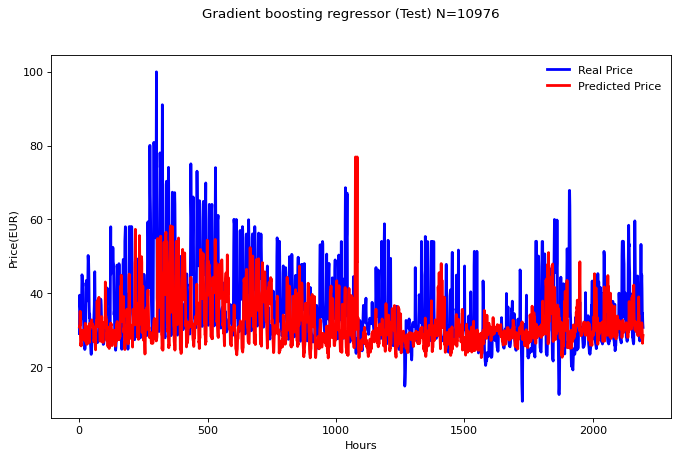

In [ ]:
import pandas as pd
import numpy as np
from IPython.display import display
from fastai.imports import *
from sklearn import metrics
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

hour_ahead = 24
n_estimators = 80
learning_rate = 0.1
Depth = 6
Min_leaf = 20
Top = 30

path = "/content/drive/MyDrive/Colab Notebooks/Project/05_Weather_FI_Extend.csv"
Merge_all = pd.read_csv(path)
dti = pd.to_datetime(Merge_all['DateTime'], format='%Y-%m-%d %H', exact=False)
Merge_all.set_index(pd.Index(dti), inplace=True)
Merge_all.drop(['DateTime'], axis=1, inplace=True)

First = Merge_all.iloc[0:11000, :]
N_index = First.shape
Y_temp = First['FI']
Y = Y_temp.iloc[hour_ahead:N_index[0]]
#Y.reset_index(drop=True, inplace=True)
#Y.columns = [''] * len(Y.columns)


X_temp1 = First.drop(First.columns.difference(['FI', 'C_SE1 > FI', 'C_FI > SE1', 'C_SE3 > FI', 'C_FI > SE3', 'C_EE > FI', 'C_FI > EE', 'F_FI > SE1', 'F_SE1 > FI', 'F_FI > SE3', 'F_SE3 > FI', 'F_FI > EE', 'F_EE > FI', 'FI Buy', 'FI Sell']), axis=1)
X_temp2 = First.drop(['FI', 'C_SE1 > FI', 'C_FI > SE1', 'C_SE3 > FI', 'C_FI > SE3', 'C_EE > FI', 'C_FI > EE', 'F_FI > SE1', 'F_SE1 > FI', 'F_FI > SE3', 'F_SE3 > FI', 'F_FI > EE', 'F_EE > FI', 'FI Buy', 'FI Sell'], axis=1)
X_temp2_index = X_temp2.index + DateOffset(hours=-hour_ahead)
X_temp2.set_index(X_temp2_index, inplace=True)
#X_temp1 = X_temp1.to_frame()
X_temp = X_temp1.join(X_temp2)
X = X_temp.iloc[0:N_index[0] - hour_ahead]

#X.reset_index(drop=True, inplace=True)
#X.columns = [''] * len(X.columns)
Pred_index = X.shape
print("Shape = "+str(Pred_index))

Y_temp = Y.copy()
Y_temp.index = Y_temp.index + DateOffset(hours=-hour_ahead)
Y_temp.rename('Y', inplace=True)
XY = X.copy()
XY = XY.join(Y_temp)
XYC = XY.corr()
YCorr = XYC.drop(First.columns.difference(['Y']), axis=1)
YCorr.sort_values(by=['Y'], inplace=True)


TopIndex = YCorr.index[(803-Top):803] 
X.drop(X.columns.difference(TopIndex), axis=1, inplace=True)


X = X.to_numpy()
Y = Y.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)



class DecisionTree():
    def __init__(self, x, y, n_features, f_idxs, idxs=None, depth=3, min_leaf=5):
        if idxs is None: idxs=np.arange(len(y))
        self.x, self.y, self.idxs, self.min_leaf, self.f_idxs = x, y, idxs, min_leaf, f_idxs
        self.depth = depth
        #print(f_idxs)
        #         print(self.depth)
        self.n_features = n_features
        self.n, self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()

    def find_varsplit(self):
        for i in self.f_idxs: self.find_better_split(i)
        if self.is_leaf: return
        x = self.split_col
        lhs = np.nonzero(x <= self.split)[0]
        rhs = np.nonzero(x > self.split)[0]
        lf_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        rf_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        self.lhs = DecisionTree(self.x, self.y, self.n_features, lf_idxs, self.idxs[lhs], depth=self.depth - 1,
                                min_leaf=self.min_leaf)
        self.rhs = DecisionTree(self.x, self.y, self.n_features, rf_idxs, self.idxs[rhs], depth=self.depth - 1,
                                min_leaf=self.min_leaf)

    def find_better_split(self, var_idx):
        x, y = self.x[self.idxs, var_idx], self.y[self.idxs]
        sort_idx = np.argsort(x)
        sort_y, sort_x = y[sort_idx], x[sort_idx]
        rhs_sum2: object
        rhs_cnt, rhs_sum, rhs_sum2 = self.n, sort_y.sum(), (sort_y ** 2).sum()
        lhs_cnt, lhs_sum, lhs_sum2 = 0, 0., 0.

        for i in range(0, self.n - self.min_leaf - 1):
            xi, yi = sort_x[i], sort_y[i]
            lhs_cnt += 1
            rhs_cnt -= 1
            lhs_sum += yi
            rhs_sum -= yi
            lhs_sum2 += yi ** 2
            rhs_sum2 -= yi ** 2
            if i < self.min_leaf or xi == sort_x[i + 1]:
                continue

            lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
            rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
            curr_score = lhs_std * lhs_cnt + rhs_std * rhs_cnt
            if curr_score < self.score:
                self.var_idx, self.score, self.split = var_idx, curr_score, xi

    @property
    def split_name(self):
        return self.x.columns[self.var_idx]

    @property
    def split_col(self):
        return self.x[self.idxs, self.var_idx]

    @property
    def is_leaf(self):
        return self.score == float('inf') or self.depth <= 0

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        t = self.lhs if xi[self.var_idx] <= self.split else self.rhs
        return t.predict_row(xi)

def std_agg(cnt, s1, s2):
    try:
        return math.sqrt((s2 / cnt) - (s1 / cnt) ** 2)
    except:
        return 0

xi = X_train
train_index = X_train.shape
yi = y_train - np.mean(y_train)
ei = 0  # initialization of error
predf = np.mean(y_train)  # initial prediction 0


def create_tree(x, y, n_features, sample_sz, depth=3, min_leaf=5):
    idxs = np.random.permutation(len(y))[:sample_sz]
    f_idxs = np.random.permutation(x.shape[1])[:n_features]
    return DecisionTree(x[idxs], y[idxs], n_features, f_idxs,
                        idxs=np.array(range(sample_sz)), depth=depth, min_leaf=min_leaf)


print("hour_ahead = " + str(hour_ahead))
print("n_estimators = " + str(n_estimators))
print("learning_rate = " + str(learning_rate))
print("Depth = " + str(Depth))
print("Min_leaf = " + str(Min_leaf))


trees = []
for i in range(n_estimators):
    tree = create_tree(xi, yi, train_index[1], train_index[0], depth=Depth, min_leaf=Min_leaf)
    predi = tree.predict(xi)
    predf = predf + learning_rate * predi
    print(str(i)+str("  ")+str(mean_absolute_error(y_train, predf)))
    ei = y_train - predf  # needed originl y here as residual always from original y
    yi = ei  # update yi as residual to reloop
    trees.append(tree)


MSE = mean_squared_error(y_train, predf, squared=True)
print("Training MSE  " + str(MSE))
RMSE = np.sqrt(MSE)
print("Training RMSE  " + str(RMSE))
MAE = mean_absolute_error(y_train, predf)
print("Training MAE  " + str(MAE))



xi = X_test
train_index = X_test.shape
yi = y_test - np.mean(y_test)
ei = 0  # initialization of error
predf = np.mean(y_test)

i = 0
for t in trees:
    predi = t.predict(X_test)
    predf = predf + learning_rate * predi
    print(str(i)+str("  ")+str(np.sqrt(mean_squared_error(y_test, predf, squared=True))))
    print(str(i)+str("  ")+str(mean_absolute_error(y_test, predf)))
    ei = y_test - predf  # needed originl y here as residual always from original y
    yi = ei  # update yi as residual to reloop

    #if i == 1:
    #   break
    i += 1


MSE = mean_squared_error(y_test, predf, squared=True)
print("Testing MSE  " + str(MSE))
RMSE = np.sqrt(MSE)
print("Testing RMSE  " + str(RMSE))
MAE = mean_absolute_error(y_test, predf)
print("Testing MAE  " + str(MAE))


plt.figure(figsize=(10, 6), dpi=80)
plt.suptitle('Gradient boosting regressor (Test) N=' + str(Pred_index[0]))
plt.plot(np.arange(len(y_test))+1, y_test, color="blue", linewidth=2.5, linestyle="-", label='Real Price')
plt.plot(np.arange(len(predf))+1, predf, color="red",  linewidth=2.5, linestyle="-", label='Predicted Price')
plt.xlabel('Hours')
plt.ylabel('Price(EUR)')
plt.legend(frameon=False)
plt.show()

Shape = (10976, 794)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


hour_ahead = 24
n_estimators = 80
learning_rate = 0.1
Depth = 6
Min_leaf = 20
0  7.195329686010099
1  6.855052261976212
2  6.558167400412261
3  6.301481893620918
4  6.081031726047085
5  5.898137783200559
6  5.739369015821024
7  5.603598847859107
8  5.485138371299179
9  5.381921551119393
10  5.2821249849481395
11  5.193840836334377
12  5.120719706011314
13  5.0591870897226165
14  4.999806914508342
15  4.948050657557531
16  4.904524218688765
17  4.865741402900976
18  4.832784499679767
19  4.799148471250529
20  4.777338008658278
21  4.754227059014316
22  4.732579485249766
23  4.715842505618629
24  4.702644581177883
25  4.691052950915666
26  4.680128303540463
27  4.670469600490772
28  4.661480948604416
29  4.649710251530391
30  4.631149163514557
31  4.622657041546362
32  4.617137171620655
33  4.609222116775942
34  4.594224855234003
35  4.583196854683272
36  4.565851826081783
37  4.553118117243919
38  4.543313925539283
39  4.535614502005264
40  4.530085847227335
41  4.51827459776435
42  4.5

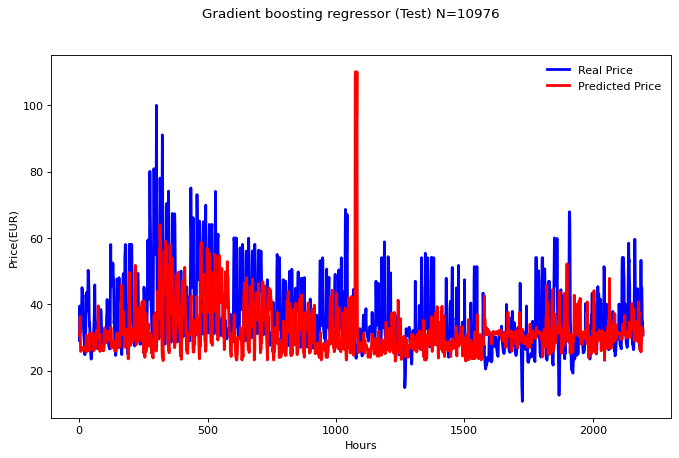

In [ ]:
import pandas as pd
import numpy as np
from IPython.display import display
from fastai.imports import *
from sklearn import metrics
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

hour_ahead = 24
n_estimators = 80
learning_rate = 0.1
Depth = 6
Min_leaf = 20
Top = 30

path = "/content/drive/MyDrive/Colab Notebooks/Project/05_Weather_FI_Extend.csv"
Merge_all = pd.read_csv(path)
dti = pd.to_datetime(Merge_all['DateTime'], format='%Y-%m-%d %H', exact=False)
Merge_all.set_index(pd.Index(dti), inplace=True)
Merge_all.drop(['DateTime'], axis=1, inplace=True)

First = Merge_all.iloc[0:11000, :]
N_index = First.shape
Y_temp = First['FI']
Y = Y_temp.iloc[hour_ahead:N_index[0]]
#Y.reset_index(drop=True, inplace=True)
#Y.columns = [''] * len(Y.columns)


X_temp1 = First.drop(First.columns.difference(['FI', 'C_SE1 > FI', 'C_FI > SE1', 'C_SE3 > FI', 'C_FI > SE3', 'C_EE > FI', 'C_FI > EE', 'F_FI > SE1', 'F_SE1 > FI', 'F_FI > SE3', 'F_SE3 > FI', 'F_FI > EE', 'F_EE > FI', 'FI Buy', 'FI Sell']), axis=1)
X_temp2 = First.drop(['FI', 'C_SE1 > FI', 'C_FI > SE1', 'C_SE3 > FI', 'C_FI > SE3', 'C_EE > FI', 'C_FI > EE', 'F_FI > SE1', 'F_SE1 > FI', 'F_FI > SE3', 'F_SE3 > FI', 'F_FI > EE', 'F_EE > FI', 'FI Buy', 'FI Sell'], axis=1)
X_temp2_index = X_temp2.index + DateOffset(hours=-hour_ahead)
X_temp2.set_index(X_temp2_index, inplace=True)
#X_temp1 = X_temp1.to_frame()
X_temp = X_temp1.join(X_temp2)
X = X_temp.iloc[0:N_index[0] - hour_ahead]

#X.reset_index(drop=True, inplace=True)
#X.columns = [''] * len(X.columns)
Pred_index = X.shape
print("Shape = "+str(Pred_index))



Y_temp = Y.copy()
Y_temp.index = Y_temp.index + DateOffset(hours=-hour_ahead)
Y_temp.rename('Y', inplace=True)
XY = X.copy()
XY = XY.join(Y_temp)
XYC2 = XY.corr(method='spearman')
YCorr2 = XYC2.drop(First.columns.difference(['Y']), axis=1)
YCorr2.sort_values(by=['Y'], inplace=True)




TopIndex = YCorr2.index[(803-Top):803] 
X.drop(X.columns.difference(TopIndex), axis=1, inplace=True)




X = X.to_numpy()
Y = Y.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)



class DecisionTree():
    def __init__(self, x, y, n_features, f_idxs, idxs=None, depth=3, min_leaf=5):
        if idxs is None: idxs=np.arange(len(y))
        self.x, self.y, self.idxs, self.min_leaf, self.f_idxs = x, y, idxs, min_leaf, f_idxs
        self.depth = depth
        #print(f_idxs)
        #         print(self.depth)
        self.n_features = n_features
        self.n, self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()

    def find_varsplit(self):
        for i in self.f_idxs: self.find_better_split(i)
        if self.is_leaf: return
        x = self.split_col
        lhs = np.nonzero(x <= self.split)[0]
        rhs = np.nonzero(x > self.split)[0]
        lf_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        rf_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        self.lhs = DecisionTree(self.x, self.y, self.n_features, lf_idxs, self.idxs[lhs], depth=self.depth - 1,
                                min_leaf=self.min_leaf)
        self.rhs = DecisionTree(self.x, self.y, self.n_features, rf_idxs, self.idxs[rhs], depth=self.depth - 1,
                                min_leaf=self.min_leaf)

    def find_better_split(self, var_idx):
        x, y = self.x[self.idxs, var_idx], self.y[self.idxs]
        sort_idx = np.argsort(x)
        sort_y, sort_x = y[sort_idx], x[sort_idx]
        rhs_sum2: object
        rhs_cnt, rhs_sum, rhs_sum2 = self.n, sort_y.sum(), (sort_y ** 2).sum()
        lhs_cnt, lhs_sum, lhs_sum2 = 0, 0., 0.

        for i in range(0, self.n - self.min_leaf - 1):
            xi, yi = sort_x[i], sort_y[i]
            lhs_cnt += 1
            rhs_cnt -= 1
            lhs_sum += yi
            rhs_sum -= yi
            lhs_sum2 += yi ** 2
            rhs_sum2 -= yi ** 2
            if i < self.min_leaf or xi == sort_x[i + 1]:
                continue

            lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
            rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
            curr_score = lhs_std * lhs_cnt + rhs_std * rhs_cnt
            if curr_score < self.score:
                self.var_idx, self.score, self.split = var_idx, curr_score, xi

    @property
    def split_name(self):
        return self.x.columns[self.var_idx]

    @property
    def split_col(self):
        return self.x[self.idxs, self.var_idx]

    @property
    def is_leaf(self):
        return self.score == float('inf') or self.depth <= 0

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        t = self.lhs if xi[self.var_idx] <= self.split else self.rhs
        return t.predict_row(xi)

def std_agg(cnt, s1, s2):
    try:
        return math.sqrt((s2 / cnt) - (s1 / cnt) ** 2)
    except:
        return 0

xi = X_train
train_index = X_train.shape
yi = y_train - np.mean(y_train)
ei = 0  # initialization of error
predf = np.mean(y_train)  # initial prediction 0


def create_tree(x, y, n_features, sample_sz, depth=3, min_leaf=5):
    idxs = np.random.permutation(len(y))[:sample_sz]
    f_idxs = np.random.permutation(x.shape[1])[:n_features]
    return DecisionTree(x[idxs], y[idxs], n_features, f_idxs,
                        idxs=np.array(range(sample_sz)), depth=depth, min_leaf=min_leaf)


print("hour_ahead = " + str(hour_ahead))
print("n_estimators = " + str(n_estimators))
print("learning_rate = " + str(learning_rate))
print("Depth = " + str(Depth))
print("Min_leaf = " + str(Min_leaf))


trees = []
for i in range(n_estimators):
    tree = create_tree(xi, yi, train_index[1], train_index[0], depth=Depth, min_leaf=Min_leaf)
    predi = tree.predict(xi)
    predf = predf + learning_rate * predi
    print(str(i)+str("  ")+str(mean_absolute_error(y_train, predf)))
    ei = y_train - predf  # needed originl y here as residual always from original y
    yi = ei  # update yi as residual to reloop
    trees.append(tree)


MSE = mean_squared_error(y_train, predf, squared=True)
print("Training MSE  " + str(MSE))
RMSE = np.sqrt(MSE)
print("Training RMSE  " + str(RMSE))
MAE = mean_absolute_error(y_train, predf)
print("Training MAE  " + str(MAE))



xi = X_test
train_index = X_test.shape
yi = y_test - np.mean(y_test)
ei = 0  # initialization of error
predf = np.mean(y_test)

i = 0
for t in trees:
    predi = t.predict(X_test)
    predf = predf + learning_rate * predi
    print(str(i)+str("  ")+str(np.sqrt(mean_squared_error(y_test, predf, squared=True))))
    print(str(i)+str("  ")+str(mean_absolute_error(y_test, predf)))
    ei = y_test - predf  # needed originl y here as residual always from original y
    yi = ei  # update yi as residual to reloop

    #if i == 1:
    #   break
    i += 1


MSE = mean_squared_error(y_test, predf, squared=True)
print("Testing MSE  " + str(MSE))
RMSE = np.sqrt(MSE)
print("Testing RMSE  " + str(RMSE))
MAE = mean_absolute_error(y_test, predf)
print("Testing MAE  " + str(MAE))


plt.figure(figsize=(10, 6), dpi=80)
plt.suptitle('Gradient boosting regressor (Test) N=' + str(Pred_index[0]))
plt.plot(np.arange(len(y_test))+1, y_test, color="blue", linewidth=2.5, linestyle="-", label='Real Price')
plt.plot(np.arange(len(predf))+1, predf, color="red",  linewidth=2.5, linestyle="-", label='Predicted Price')
plt.xlabel('Hours')
plt.ylabel('Price(EUR)')
plt.legend(frameon=False)
plt.show()

Shape = (10976, 794)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


hour_ahead = 24
n_estimators = 80
learning_rate = 0.1
Depth = 6
Min_leaf = 20
0  7.2231168465836815
1  6.902849805309089
2  6.625833324656986
3  6.385977868004374
4  6.178329861785184
5  6.006618492877333
6  5.85029158982048
7  5.7253170563447275
8  5.613868150584256
9  5.5129587739955115
10  5.433154401192261
11  5.3636225914752025
12  5.298641502348888
13  5.243237091677003
14  5.197821075861772
15  5.15803364919743
16  5.121816180431445
17  5.096509499886099
18  5.074438823945093
19  5.052744246403748
20  5.033682430040899
21  5.0179740980800895
22  5.004164366490942
23  4.992505575664842
24  4.9813893470631925
25  4.973238082650698
26  4.964530613717091
27  4.945110011820421
28  4.938792075417722
29  4.9330846798525725
30  4.92573793671089
31  4.922682420924931
32  4.915806657186294
33  4.910208793957896
34  4.904984421507803
35  4.90116959608358
36  4.897675620578903
37  4.894660989687861
38  4.889706113908727
39  4.887689673619935
40  4.883892011249089
41  4.882151129262064
42  4

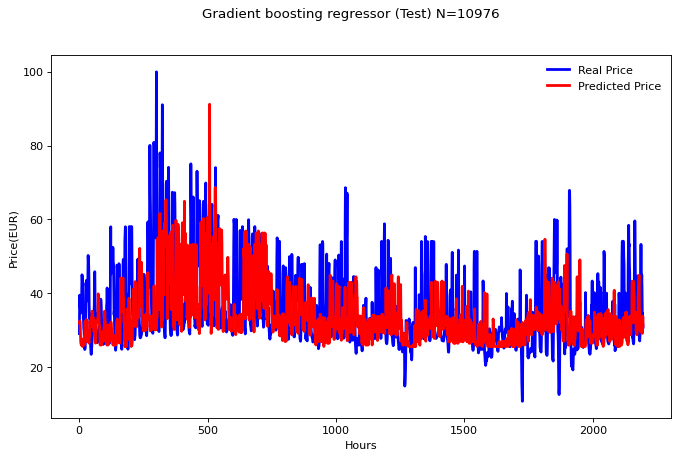

In [ ]:
import pandas as pd
import numpy as np
from IPython.display import display
from fastai.imports import *
from sklearn import metrics
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

hour_ahead = 24
n_estimators = 80
learning_rate = 0.1
Depth = 6
Min_leaf = 20
Top = 30

path = "/content/drive/MyDrive/Colab Notebooks/Project/05_Weather_FI_Extend.csv"
Merge_all = pd.read_csv(path)
dti = pd.to_datetime(Merge_all['DateTime'], format='%Y-%m-%d %H', exact=False)
Merge_all.set_index(pd.Index(dti), inplace=True)
Merge_all.drop(['DateTime'], axis=1, inplace=True)

First = Merge_all.iloc[0:11000, :]
N_index = First.shape
Y_temp = First['FI']
Y = Y_temp.iloc[hour_ahead:N_index[0]]
#Y.reset_index(drop=True, inplace=True)
#Y.columns = [''] * len(Y.columns)


X_temp1 = First.drop(First.columns.difference(['FI', 'C_SE1 > FI', 'C_FI > SE1', 'C_SE3 > FI', 'C_FI > SE3', 'C_EE > FI', 'C_FI > EE', 'F_FI > SE1', 'F_SE1 > FI', 'F_FI > SE3', 'F_SE3 > FI', 'F_FI > EE', 'F_EE > FI', 'FI Buy', 'FI Sell']), axis=1)
X_temp2 = First.drop(['FI', 'C_SE1 > FI', 'C_FI > SE1', 'C_SE3 > FI', 'C_FI > SE3', 'C_EE > FI', 'C_FI > EE', 'F_FI > SE1', 'F_SE1 > FI', 'F_FI > SE3', 'F_SE3 > FI', 'F_FI > EE', 'F_EE > FI', 'FI Buy', 'FI Sell'], axis=1)
X_temp2_index = X_temp2.index + DateOffset(hours=-hour_ahead)
X_temp2.set_index(X_temp2_index, inplace=True)
#X_temp1 = X_temp1.to_frame()
X_temp = X_temp1.join(X_temp2)
X = X_temp.iloc[0:N_index[0] - hour_ahead]

#X.reset_index(drop=True, inplace=True)
#X.columns = [''] * len(X.columns)
Pred_index = X.shape
print("Shape = "+str(Pred_index))

from sklearn.linear_model import LinearRegression
model2 = LinearRegression()
model2.fit(X, Y)
importance2 = model2.coef_
FeatureR = []
FeatureR_index = X.columns
for i,v in enumerate(importance2):
    FeatureR.append(v)

Yfri = pd.DataFrame({'Index':FeatureR_index})
Yfr = pd.DataFrame({'Y':FeatureR})
Yfr.index = Yfri['Index']
YfrABS = Yfr.abs()
YfrABS.sort_values(by=['Y'], inplace=True)




TopIndex = YfrABS.index[(803-Top):803] 
X.drop(X.columns.difference(TopIndex), axis=1, inplace=True)




X = X.to_numpy()
Y = Y.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)



class DecisionTree():
    def __init__(self, x, y, n_features, f_idxs, idxs=None, depth=3, min_leaf=5):
        if idxs is None: idxs=np.arange(len(y))
        self.x, self.y, self.idxs, self.min_leaf, self.f_idxs = x, y, idxs, min_leaf, f_idxs
        self.depth = depth
        #print(f_idxs)
        #         print(self.depth)
        self.n_features = n_features
        self.n, self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()

    def find_varsplit(self):
        for i in self.f_idxs: self.find_better_split(i)
        if self.is_leaf: return
        x = self.split_col
        lhs = np.nonzero(x <= self.split)[0]
        rhs = np.nonzero(x > self.split)[0]
        lf_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        rf_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        self.lhs = DecisionTree(self.x, self.y, self.n_features, lf_idxs, self.idxs[lhs], depth=self.depth - 1,
                                min_leaf=self.min_leaf)
        self.rhs = DecisionTree(self.x, self.y, self.n_features, rf_idxs, self.idxs[rhs], depth=self.depth - 1,
                                min_leaf=self.min_leaf)

    def find_better_split(self, var_idx):
        x, y = self.x[self.idxs, var_idx], self.y[self.idxs]
        sort_idx = np.argsort(x)
        sort_y, sort_x = y[sort_idx], x[sort_idx]
        rhs_sum2: object
        rhs_cnt, rhs_sum, rhs_sum2 = self.n, sort_y.sum(), (sort_y ** 2).sum()
        lhs_cnt, lhs_sum, lhs_sum2 = 0, 0., 0.

        for i in range(0, self.n - self.min_leaf - 1):
            xi, yi = sort_x[i], sort_y[i]
            lhs_cnt += 1
            rhs_cnt -= 1
            lhs_sum += yi
            rhs_sum -= yi
            lhs_sum2 += yi ** 2
            rhs_sum2 -= yi ** 2
            if i < self.min_leaf or xi == sort_x[i + 1]:
                continue

            lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
            rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
            curr_score = lhs_std * lhs_cnt + rhs_std * rhs_cnt
            if curr_score < self.score:
                self.var_idx, self.score, self.split = var_idx, curr_score, xi

    @property
    def split_name(self):
        return self.x.columns[self.var_idx]

    @property
    def split_col(self):
        return self.x[self.idxs, self.var_idx]

    @property
    def is_leaf(self):
        return self.score == float('inf') or self.depth <= 0

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        t = self.lhs if xi[self.var_idx] <= self.split else self.rhs
        return t.predict_row(xi)

def std_agg(cnt, s1, s2):
    try:
        return math.sqrt((s2 / cnt) - (s1 / cnt) ** 2)
    except:
        return 0

xi = X_train
train_index = X_train.shape
yi = y_train - np.mean(y_train)
ei = 0  # initialization of error
predf = np.mean(y_train)  # initial prediction 0


def create_tree(x, y, n_features, sample_sz, depth=3, min_leaf=5):
    idxs = np.random.permutation(len(y))[:sample_sz]
    f_idxs = np.random.permutation(x.shape[1])[:n_features]
    return DecisionTree(x[idxs], y[idxs], n_features, f_idxs,
                        idxs=np.array(range(sample_sz)), depth=depth, min_leaf=min_leaf)


print("hour_ahead = " + str(hour_ahead))
print("n_estimators = " + str(n_estimators))
print("learning_rate = " + str(learning_rate))
print("Depth = " + str(Depth))
print("Min_leaf = " + str(Min_leaf))


trees = []
for i in range(n_estimators):
    tree = create_tree(xi, yi, train_index[1], train_index[0], depth=Depth, min_leaf=Min_leaf)
    predi = tree.predict(xi)
    predf = predf + learning_rate * predi
    print(str(i)+str("  ")+str(mean_absolute_error(y_train, predf)))
    ei = y_train - predf  # needed originl y here as residual always from original y
    yi = ei  # update yi as residual to reloop
    trees.append(tree)


MSE = mean_squared_error(y_train, predf, squared=True)
print("Training MSE  " + str(MSE))
RMSE = np.sqrt(MSE)
print("Training RMSE  " + str(RMSE))
MAE = mean_absolute_error(y_train, predf)
print("Training MAE  " + str(MAE))



xi = X_test
train_index = X_test.shape
yi = y_test - np.mean(y_test)
ei = 0  # initialization of error
predf = np.mean(y_test)

i = 0
for t in trees:
    predi = t.predict(X_test)
    predf = predf + learning_rate * predi
    print(str(i)+str("  ")+str(np.sqrt(mean_squared_error(y_test, predf, squared=True))))
    print(str(i)+str("  ")+str(mean_absolute_error(y_test, predf)))
    ei = y_test - predf  # needed originl y here as residual always from original y
    yi = ei  # update yi as residual to reloop

    #if i == 1:
    #   break
    i += 1


MSE = mean_squared_error(y_test, predf, squared=True)
print("Testing MSE  " + str(MSE))
RMSE = np.sqrt(MSE)
print("Testing RMSE  " + str(RMSE))
MAE = mean_absolute_error(y_test, predf)
print("Testing MAE  " + str(MAE))


plt.figure(figsize=(10, 6), dpi=80)
plt.suptitle('Gradient boosting regressor (Test) N=' + str(Pred_index[0]))
plt.plot(np.arange(len(y_test))+1, y_test, color="blue", linewidth=2.5, linestyle="-", label='Real Price')
plt.plot(np.arange(len(predf))+1, predf, color="red",  linewidth=2.5, linestyle="-", label='Predicted Price')
plt.xlabel('Hours')
plt.ylabel('Price(EUR)')
plt.legend(frameon=False)
plt.show()